In [79]:
import pandas as pd
import numpy as np
import requests
import json
import csv
from tqdm import tqdm
import re

Create edges of adjacency for all counties

In [80]:
with open("County_Adjacency.txt") as file:
    lines = [line for line in file]

#read in as dictionary

adjacency_dict = {}

for line in lines:
    if line[0:2] != '\t\t':
        split_list = re.split('\t|\n', line)
        fip_code = split_list[1]
        adjacency_dict[fip_code] = []
        if fip_code != split_list[3]:
            adjacency_dict[fip_code].append(split_list[3])
    else:
        adjacency_dict[fip_code].append(line[-6:-1])

#convert to non-duplicated edges
edges = []

for key in adjacency_dict.keys():
    fip_list = adjacency_dict[key]
    for i in fip_list:
        edge = [key, i]
        if [[i, key]] in edges:
            pass
        else:
            edges.append(edge)
 

#pd.DataFrame(edges).to_csv('edge_values.csv')
edges = pd.DataFrame(edges)

#remove US territories
non_states = ['72', '69', '60', '78', '66']
edges['state1'] = edges[0].astype(str).str[0:2]
edges['state2'] = edges[1].astype(str).str[0:2]
edges = edges[~edges['state1'].isin(non_states)]
edges = edges[~edges['state2'].isin(non_states)]
edges = edges[[0, 1]]

#make sure both directions represented
edges = pd.concat([edges[[0,1]], edges[[1,0]]]).drop_duplicates()

#ensure all codes are five digits
for i in range(len(edges)):
    if len(edges.iloc[i][0]) < 5:
        print(edges.iloc[i][0])
    if len(edges.iloc[i][1]) < 5:
        print(edges.iloc[i][1])
        
edges


,0,1
0,01001,01021
1,01001,01047
2,01001,01051
3,01001,01085
4,01001,01101
...,...,...
21303,56045,56005
21304,56045,56009
21305,56045,56011
21306,56045,56027


Pull in the commuter flows and join onto the edges for flow

In [86]:
#read in data and clean up 
df_comms = pd.read_csv('commuter_flows_data.csv',  header = 7 )

#remove non states
non_states = ['72', '69', '60', '78', '66']

df_comms = df_comms[~df_comms['State FIPS Code'].isin(non_states)]
df_comms = df_comms[~df_comms['State FIPS Code.1'].isin(non_states)]
df_comms = df_comms.dropna(subset=['State FIPS Code'])
df_comms = df_comms.dropna(subset=['County FIPS Code'])

df_comms = df_comms.dropna(subset=['State FIPS Code.1'])
df_comms = df_comms.dropna(subset=['County FIPS Code.1'])



def five_digit_conversion(df_comms, state_column, county_column):
    fips_list = []

    for i in tqdm(range(len(df_comms))):
        ST = str(int(df_comms.iloc[i][state_column]))
        CO = str(int(df_comms.iloc[i][county_column]))

        ST_add_zeros = 2 - len(ST)
        CO_add_zeros = 3 - len(CO)

        ST = '0'*ST_add_zeros + ST
        CO = '0'*CO_add_zeros + CO

        fips_list.append(ST + CO)
    
    return fips_list

df_comms['FULL_FIPS'] = five_digit_conversion(df_comms, 'State FIPS Code', 'County FIPS Code')
df_comms['FULL_FIPS1'] = five_digit_conversion(df_comms, 'State FIPS Code.1', 'County FIPS Code.1')


df_comms = df_comms[['FULL_FIPS', 'FULL_FIPS1', 'Workers in Commuting Flow', 'Margin of Error']]
df_comms.columns = ['Origin', 'Destination', 'Workers in Commuting Flow', 'Margin of Error']
print(df_comms.head())

#remove commas from column
df_comms['Workers in Commuting Flow'] = df_comms['Workers in Commuting Flow'].str.replace(',', '')

df_comms
#df_comms.to_csv('cleaned_commuter_flows.csv', index = False)


c:\Users\zapate\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 119245/119245 [00:20<00:00, 5696.49it/s]

  Origin Destination Workers in Commuting Flow Margin of Error
0  01001       01001                     8,671             681
1  01001       01003                         8              12
2  01001       01007                        11              19
3  01001       01013                         9              17
4  01001       01021                       508             195


,Origin,Destination,Workers in Commuting Flow,Margin of Error
0,01001,01001,8671,681
1,01001,01003,8,12
2,01001,01007,11,19
3,01001,01013,9,17
4,01001,01021,508,195
...,...,...,...,...
120535,56045,46047,27,42
120536,56045,46081,35,55
120537,56045,56005,595,163
120538,56045,56011,74,46


In [108]:
#create join edges with commuters
edges1 = edges.rename(columns = {0:'origin', 1:'destination'})
edges_w_commuters = edges1.merge(df_comms, how = 'left', left_on = ['origin', 'destination'], right_on = ['Origin', 'Destination']).dropna()
edges_w_commuters = edges_w_commuters[['origin', 'destination', 'Workers in Commuting Flow']]
print(edges_w_commuters)

lesser_fips, greater_fips = [], []

for i in tqdm(range(len(edges_w_commuters))):
    orig, dest = edges_w_commuters.iloc[i]['origin'], edges_w_commuters.iloc[i]['destination']
    if orig <= dest:
        lesser_fips.append(orig)
        greater_fips.append(dest)
    else:
        lesser_fips.append(dest)
        greater_fips.append(orig)

edges_w_commuters['lesser_fips'] = lesser_fips
edges_w_commuters['greater_fips'] = greater_fips

edges_w_commuters['Workers in Commuting Flow'] = edges_w_commuters['Workers in Commuting Flow'].astype(float)

#grouping
edges_w_commuters_grouped = edges_w_commuters.groupby(['lesser_fips', 'greater_fips']).sum('Workers in Commuting Flow').reset_index()



      origin destination Workers in Commuting Flow
0      01001       01021                       508
1      01001       01047                       406
2      01001       01051                      2188
3      01001       01085                       126
4      01001       01101                     11486
...      ...         ...                       ...
21300  56045       46033                        32
21301  56045       46081                        35
21303  56045       56005                       595
21305  56045       56011                        74
21307  56045       56045                      2048

[19662 rows x 3 columns]


100%|██████████| 19662/19662 [00:01<00:00, 12424.67it/s]


In [112]:
edges_w_commuters_grouped

,origin_grouped,destination_grouped,grouped_workers_in_commuting_flow
0,01001,01021,648.0
1,01001,01047,535.0
2,01001,01051,4502.0
3,01001,01085,263.0
4,01001,01101,12639.0
...,...,...,...
11583,56037,56041,819.0
11584,56039,56039,13921.0
11585,56041,56041,8090.0
11586,56043,56043,3386.0


In [113]:
#concating switched fips code values to be able to do all calculations off the origin value
edges_w_commuters_grouped.columns = ['origin_grouped', 'destination_grouped', 'grouped_workers_in_commuting_flow']
copied_edges_w_commuters_grouped = edges_w_commuters_grouped.copy()
copied_edges_w_commuters_grouped.columns = ['destination_grouped', 'origin_grouped', 'grouped_workers_in_commuting_flow']
concat_df = pd.concat([edges_w_commuters_grouped, copied_edges_w_commuters_grouped]).drop_duplicates()
concat_df


,origin_grouped,destination_grouped,grouped_workers_in_commuting_flow
0,01001,01021,648.0
1,01001,01047,535.0
2,01001,01051,4502.0
3,01001,01085,263.0
4,01001,01101,12639.0
...,...,...,...
11575,56039,56029,229.0
11576,56043,56029,12.0
11580,56037,56035,156.0
11581,56039,56035,495.0


In [115]:
county_sums = concat_df.groupby(['origin_grouped']).sum('grouped_workers_in_commuting_flow').reset_index()
county_sums.columns = ['origin_grouped', 'county_level_total_commuting_flow']
concat_df_w_percent =  concat_df.merge(county_sums, how='left', left_on = ['origin_grouped'], right_on = ['origin_grouped'])
concat_df_w_percent['percent_of_commuters'] = concat_df_w_percent['grouped_workers_in_commuting_flow'] / concat_df_w_percent['county_level_total_commuting_flow']
concat_df_w_percent

,origin_grouped,destination_grouped,grouped_workers_in_commuting_flow,county_level_total_commuting_flow,percent_of_commuters
0,01001,01021,648.0,18587.0,0.034863
1,01001,01047,535.0,18587.0,0.028784
2,01001,01051,4502.0,18587.0,0.242212
3,01001,01085,263.0,18587.0,0.014150
4,01001,01101,12639.0,18587.0,0.679991
...,...,...,...,...,...
20451,56039,56029,229.0,18458.0,0.012407
20452,56043,56029,12.0,3864.0,0.003106
20453,56037,56035,156.0,21992.0,0.007093
20454,56039,56035,495.0,18458.0,0.026818


In [129]:
#read in data and create five digit fips code
df = pd.read_csv('C:/Users/zapate/Desktop/Year 2 Modeling/COUNTY_Modeling_IMPUTED_8_4.csv')

fips_list = []

for i in range(len(df)):
    ST = str(df['STATE_CODE'][i])
    CO = str(df['COUNTY_CODE'][i])

    ST_add_zeros = 2 - len(ST)
    CO_add_zeros = 3 - len(CO)

    ST = '0'*ST_add_zeros + ST
    CO = '0'*CO_add_zeros + CO

    fips_list.append(ST + CO)

df['full_fips_code'] = fips_list



In [130]:
df1 = concat_df_w_percent[['origin_grouped', 'destination_grouped','percent_of_commuters']].merge(df[['full_fips_code','YEAR', 'VMT', 'POPULATION', 'True_GDP', 'TOTAL_EMISSIONS']], how = 'left', left_on = ['destination_grouped'], right_on = ['full_fips_code'])
df1['distributed_VMT'] = df1['VMT'].astype(float) * df1['percent_of_commuters']
df1['distributed_POPULATION'] = df1['POPULATION'].astype(float) * df1['percent_of_commuters']
df1['distributed_GDP'] = df1['True_GDP'].astype(float) * df1['percent_of_commuters']
df1['distributed_EMISSIONS'] = df1['TOTAL_EMISSIONS'].astype(float) * df1['percent_of_commuters']
#df1 = df1[['origin_grouped', 'destination_grouped', 'full_fips_code', 'YEAR', 'distributed_VMT', 'distributed_POPULATION', 'distributed_GDP', 'distributed_EMISSIONS']]
df1_summed = df1.groupby(['origin_grouped', 'YEAR']).sum(['distributed_VMT', 'distributed_POPULATION', 'distributed_GDP', 'distributed_EMISSIONS']).reset_index()
df1_summed = df1_summed[['origin_grouped', 'YEAR', 'distributed_VMT', 'distributed_POPULATION', 'distributed_GDP', 'distributed_EMISSIONS']]
df_final = df.merge(df1_summed, how = 'left', left_on = ['YEAR', 'full_fips_code'], right_on = ['YEAR', 'origin_grouped'])
df_final


,Unnamed: 0,STATE_CODE,COUNTY_CODE,YEAR,VMT,POPULATION,TOTAL_EMISSIONS,True_GDP,True_Fips,Unemployment_Rate,...,TELEWORK,distributed_UPT,GEMS_Typo,USDA_UIC,full_fips_code,origin_grouped,distributed_VMT,distributed_POPULATION,distributed_GDP,distributed_EMISSIONS
0,0,1,1,2000,2.744493e+08,44021.0,NaN,NaN,NaN,4.1,...,NaN,0.0,F,2.0,01001,01001,1.050399e+09,170865.167644,0.000000e+00,0.000000
1,1,1,3,2000,1.196020e+09,141342.0,NaN,NaN,NaN,3.7,...,NaN,0.0,C,2.0,01003,01003,1.714598e+09,355858.217278,0.000000e+00,0.000000
2,2,1,5,2000,1.276073e+08,29015.0,NaN,NaN,NaN,5.6,...,NaN,0.0,C,6.0,01005,01005,1.465920e+08,24456.548848,0.000000e+00,0.000000
3,3,1,7,2000,9.060923e+07,19913.0,NaN,NaN,NaN,5.4,...,NaN,0.0,D,1.0,01007,01007,2.059776e+09,307787.742513,0.000000e+00,0.000000
4,4,1,9,2000,2.181014e+08,51107.0,NaN,NaN,NaN,3.5,...,NaN,0.0,D,1.0,01009,01009,3.037363e+09,465785.591445,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60865,60865,56,37,2020,8.070806e+08,42190.0,896451.459129,3344988.0,56037.0,7.5,...,0.087175,0.0,C,8.0,56037,56037,7.707645e+08,40536.752637,3.189037e+06,857766.536819
60866,60866,56,39,2020,1.738602e+08,23377.0,272610.823838,2308166.0,56039.0,6.0,...,0.112992,0.0,D,8.0,56039,56039,1.553552e+08,21249.939484,1.947034e+06,235822.648580
60867,60867,56,41,2020,2.682344e+08,20457.0,341765.799203,785684.0,56041.0,6.4,...,0.087175,0.0,D,8.0,56041,56041,3.107170e+08,22151.026272,1.028126e+06,380283.624486
60868,60868,56,43,2020,4.965127e+07,7658.0,64261.255841,345111.0,56043.0,5.3,...,0.053399,0.0,B,11.0,56043,56043,5.438330e+07,8285.645963,3.816193e+05,70533.029082


In [133]:
df_final.drop(columns = ['Unnamed: 0']).to_csv('modeling_data_w_adjacent_county_calulation.csv', index = False)

# OLD CODE

Read in modeling data, create total sum of adjacent VMT

In [30]:
edges = edges.rename(columns = {0:'origin', 1:'destination'})
df1 = edges.merge(df[['full_fips_code','YEAR', 'VMT', 'POPULATION', 'True_GDP', 'TOTAL_EMISSIONS']], how = 'left', left_on = ['destination'], right_on = ['full_fips_code'])
summed_data = df1.groupby(['origin','YEAR']).sum(['VMT', 'POPULATION', 'True_GDP', 'TOTAL_EMISSIONS']).reset_index()
summed_data.columns = ['origin', 'YEAR', 'adjacent_VMT', 'adjacent_POPULATION', 'adjacent_GDP', 'adjacent_EMISSIONS']

In [31]:
df = df.merge(summed_data, how = 'left', left_on = ['full_fips_code', 'YEAR'], right_on = ['origin', 'YEAR'])
df

,Unnamed: 0,STATE_CODE,COUNTY_CODE,YEAR,VMT,POPULATION,TOTAL_EMISSIONS,True_GDP,True_Fips,Unemployment_Rate,...,TELEWORK,distributed_UPT,GEMS_Typo,USDA_UIC,full_fips_code,origin,adjacent_VMT,adjacent_POPULATION,adjacent_GDP,adjacent_EMISSIONS
0,0,1,1,2000,2.744493e+08,44021.0,NaN,NaN,NaN,4.1,...,NaN,0.0,F,2.0,01001,01001,2.384363e+09,389154.0,0.0,0.000000e+00
1,1,1,3,2000,1.196020e+09,141342.0,NaN,NaN,NaN,3.7,...,NaN,0.0,C,2.0,01003,01003,3.854697e+09,803362.0,0.0,0.000000e+00
2,2,1,5,2000,1.276073e+08,29015.0,NaN,NaN,NaN,5.6,...,NaN,0.0,C,6.0,01005,01005,9.294242e+08,156251.0,0.0,0.000000e+00
3,3,1,7,2000,9.060923e+07,19913.0,NaN,NaN,NaN,5.4,...,NaN,0.0,D,1.0,01007,01007,6.770677e+09,1042021.0,0.0,0.000000e+00
4,4,1,9,2000,2.181014e+08,51107.0,NaN,NaN,NaN,3.5,...,NaN,0.0,D,1.0,01009,01009,6.583583e+09,1060903.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60865,60865,56,37,2020,8.070806e+08,42190.0,896451.459129,3344988.0,56037.0,7.5,...,0.087175,0.0,C,8.0,56037,56037,2.763250e+09,200489.0,13913205.0,3.008354e+06
60866,60866,56,39,2020,1.738602e+08,23377.0,272610.823838,2308166.0,56039.0,6.0,...,0.112992,0.0,D,8.0,56039,56039,2.171891e+09,378348.0,20055286.0,2.871878e+06
60867,60867,56,41,2020,2.682344e+08,20457.0,341765.799203,785684.0,56041.0,6.4,...,0.087175,0.0,D,8.0,56041,56041,1.884050e+09,127286.0,8212989.0,2.020111e+06
60868,60868,56,43,2020,4.965127e+07,7658.0,64261.255841,345111.0,56043.0,5.3,...,0.053399,0.0,B,11.0,56043,56043,1.263935e+09,181367.0,9444080.0,1.739361e+06


,Unnamed: 0,STATE_CODE,COUNTY_CODE,YEAR,VMT,POPULATION,TOTAL_EMISSIONS,True_GDP,True_Fips,Unemployment_Rate,Charging_Stations,LNMILES,TMS,TELEWORK,distributed_UPT,GEMS_Typo,USDA_UIC,full_fips_code
0,0,1,1,2000,2.744493e+08,44021.0,NaN,NaN,NaN,4.1,0.0,1980.320,NaN,NaN,0.0,F,2.0,01001
1,1,1,3,2000,1.196020e+09,141342.0,NaN,NaN,NaN,3.7,0.0,4905.660,NaN,NaN,0.0,C,2.0,01003
2,2,1,5,2000,1.276073e+08,29015.0,NaN,NaN,NaN,5.6,0.0,2479.120,NaN,NaN,0.0,C,6.0,01005
3,3,1,7,2000,9.060923e+07,19913.0,NaN,NaN,NaN,5.4,0.0,1804.750,NaN,NaN,0.0,D,1.0,01007
4,4,1,9,2000,2.181014e+08,51107.0,NaN,NaN,NaN,3.5,0.0,2763.560,NaN,NaN,0.0,D,1.0,01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60865,60865,56,37,2020,8.070806e+08,42190.0,896451.459129,3344988.0,56037.0,7.5,3.0,5252.604,0.007363,0.087175,0.0,C,8.0,56037
60866,60866,56,39,2020,1.738602e+08,23377.0,272610.823838,2308166.0,56039.0,6.0,21.0,1475.236,0.004938,0.112992,0.0,D,8.0,56039
60867,60867,56,41,2020,2.682344e+08,20457.0,341765.799203,785684.0,56041.0,6.4,1.0,1615.570,0.007363,0.087175,0.0,D,8.0,56041
60868,60868,56,43,2020,4.965127e+07,7658.0,64261.255841,345111.0,56043.0,5.3,0.0,1371.434,0.005502,0.053399,0.0,B,11.0,56043


# Commuter Flow Data

c:\Users\zapate\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,State FIPS Code,County FIPS Code,State Name,County Name,State FIPS Code.1,County FIPS Code.1,State Name.1,County Name.1,Workers in Commuting Flow,Margin of Error
0,1,1.0,Alabama,Autauga County,1.0,1.0,Alabama,Autauga County,"8,671",681
1,1,1.0,Alabama,Autauga County,1.0,3.0,Alabama,Baldwin County,8,12
2,1,1.0,Alabama,Autauga County,1.0,7.0,Alabama,Bibb County,11,19
3,1,1.0,Alabama,Autauga County,1.0,13.0,Alabama,Butler County,9,17
4,1,1.0,Alabama,Autauga County,1.0,21.0,Alabama,Chilton County,508,195
...,...,...,...,...,...,...,...,...,...,...
120535,56,45.0,Wyoming,Weston County,46.0,47.0,South Dakota,Fall River County,27,42
120536,56,45.0,Wyoming,Weston County,46.0,81.0,South Dakota,Lawrence County,35,55
120537,56,45.0,Wyoming,Weston County,56.0,5.0,Wyoming,Campbell County,595,163
120538,56,45.0,Wyoming,Weston County,56.0,11.0,Wyoming,Crook County,74,46


In [35]:
"""
def five_digit_conversion(df_comms, state_column, county_column):
    fips_list = []

    for i in tqdm(range(len(df_comms))):
        ST = str(int(df_comms.iloc[i][state_column]))
        CO = str(int(df_comms.iloc[i][county_column]))

        ST_add_zeros = 2 - len(ST)
        CO_add_zeros = 3 - len(CO)

        ST = '0'*ST_add_zeros + ST
        CO = '0'*CO_add_zeros + CO

        fips_list.append(ST + CO)
    
    return fips_list

df_comms['FULL_FIPS'] = five_digit_conversion(df_comms, 'State FIPS Code', 'County FIPS Code')
df_comms['FULL_FIPS1'] = five_digit_conversion(df_comms, 'State FIPS Code.1', 'County FIPS Code.1')


df_comms = df_comms[['FULL_FIPS', 'FULL_FIPS1', 'Workers in Commuting Flow', 'Margin of Error']]
df_comms.columns = ['Origin', 'Destination', 'Workers in Commuting Flow', 'Margin of Error']
print(df_comms.head())

#remove commas from column
df_comms['Workers in Commuting Flow'] = df_comms['Workers in Commuting Flow'].str.replace(',', '')


#df_comms.to_csv('cleaned_commuter_flows.csv', index = False)
"""

"\ndef five_digit_conversion(df_comms, state_column, county_column):\n    fips_list = []\n\n    for i in tqdm(range(len(df_comms))):\n        ST = str(int(df_comms.iloc[i][state_column]))\n        CO = str(int(df_comms.iloc[i][county_column]))\n\n        ST_add_zeros = 2 - len(ST)\n        CO_add_zeros = 3 - len(CO)\n\n        ST = '0'*ST_add_zeros + ST\n        CO = '0'*CO_add_zeros + CO\n\n        fips_list.append(ST + CO)\n    \n    return fips_list\n\ndf_comms['FULL_FIPS'] = five_digit_conversion(df_comms, 'State FIPS Code', 'County FIPS Code')\ndf_comms['FULL_FIPS1'] = five_digit_conversion(df_comms, 'State FIPS Code.1', 'County FIPS Code.1')\n\n\ndf_comms = df_comms[['FULL_FIPS', 'FULL_FIPS1', 'Workers in Commuting Flow', 'Margin of Error']]\ndf_comms.columns = ['Origin', 'Destination', 'Workers in Commuting Flow', 'Margin of Error']\nprint(df_comms.head())\n\n#remove commas from column\ndf_comms['Workers in Commuting Flow'] = df_comms['Workers in Commuting Flow'].str.replace(','

In [59]:
df_comms = pd.read_csv('cleaned_commuter_flows.csv', dtype = {'Origin': str, 'Destination': str})[['Origin', 'Destination', 'Workers in Commuting Flow','Margin of Error']]
df_comms

,Origin,Destination,Workers in Commuting Flow,Margin of Error
0,01001,01001,8671,681
1,01001,01003,8,12
2,01001,01007,11,19
3,01001,01013,9,17
4,01001,01021,508,195
...,...,...,...,...
119240,56045,46047,27,42
119241,56045,46081,35,55
119242,56045,56005,595,163
119243,56045,56011,74,46


In [72]:
lesser_fips, greater_fips = [], []

for i in tqdm(range(len(df_comms))):
    orig, dest = df_comms.iloc[i]['Origin'], df_comms.iloc[i]['Destination']
    if orig <= dest:
        lesser_fips.append(orig)
        greater_fips.append(dest)
    else:
        lesser_fips.append(dest)
        greater_fips.append(orig)

df_comms['lesser_fips'] = lesser_fips
df_comms['greater_fips'] = greater_fips

df_comms_grouped = df_comms.groupby(['lesser_fips', 'greater_fips']).sum('Workers in Commuting Flow').reset_index()
df_comms_grouped

100%|██████████| 119245/119245 [00:13<00:00, 8567.35it/s]


,lesser_fips,greater_fips,Workers in Commuting Flow
0,01001,01001,8671
1,01001,01003,8
2,01001,01007,11
3,01001,01011,77
4,01001,01013,20
...,...,...,...
93499,56037,56041,819
93500,56039,56039,13921
93501,56041,56041,8090
93502,56043,56043,3386


In [70]:
df_

,lesser_fips,greater_fips,Workers in Commuting Flow
0,01001,01001,8671
1,01001,01003,8
2,01001,01007,11
3,01001,01011,77
4,01001,01013,20
...,...,...,...
93499,56037,56041,819
93500,56039,56039,13921
93501,56041,56041,8090
93502,56043,56043,3386


In [71]:
df_comms 

,Origin,Destination,Workers in Commuting Flow,Margin of Error,lesser_fips,greater_fips
0,01001,01001,8671,681,01001,01001
1,01001,01003,8,12,01001,01003
2,01001,01007,11,19,01001,01007
3,01001,01013,9,17,01001,01013
4,01001,01021,508,195,01001,01021
...,...,...,...,...,...,...
119240,56045,46047,27,42,46047,56045
119241,56045,46081,35,55,46081,56045
119242,56045,56005,595,163,56005,56045
119243,56045,56011,74,46,56011,56045


In [12]:
#make sure we have the direction both ways
#df_comm1 = df_comms.copy()
#df_comm1.columns = ['Destination','Origin', 'Workers in Commuting Flow','Margin of Error']
#df_comms = pd.concat([df_comms, df_comms1]).drop
#df_comms

In [11]:
summed_commuters = df_comms.groupby(['Origin']).sum().reset_index().rename(columns = {'Workers in Commuting Flow': 'Summed Commuters'})
df_comms1 = df_comms.merge(summed_commuters, how = 'left', left_on = ['Origin'], right_on = ['Origin'])
df_comms1['Percent_commuters'] = df_comms1['Workers in Commuting Flow'] /  df_comms1['Summed Commuters']
df_comms1

,Origin,Destination,Workers in Commuting Flow,Margin of Error,Summed Commuters,Percent_commuters
0,01001,01001,8671,681,24949,0.347549
1,01001,01003,8,12,24949,0.000321
2,01001,01007,11,19,24949,0.000441
3,01001,01013,9,17,24949,0.000361
4,01001,01021,508,195,24949,0.020362
...,...,...,...,...,...,...
119240,56045,46047,27,42,2832,0.009534
119241,56045,46081,35,55,2832,0.012359
119242,56045,56005,595,163,2832,0.210099
119243,56045,56011,74,46,2832,0.026130


In [19]:
df_comms1[df_comms1['Destination'] == '01001']

,Origin,Destination,Workers in Commuting Flow,Margin of Error,Summed Commuters,Percent_commuters
0,01001,01001,8671,681,24949,0.347549
191,01011,01001,77,106,3985,0.019322
206,01013,01001,11,14,7894,0.001393
353,01021,01001,140,80,17573,0.007967
413,01025,01001,14,24,8056,0.001738
558,01033,01001,21,26,23216,0.000905
613,01037,01001,55,56,4077,0.013490
631,01039,01001,10,14,14649,0.000683
685,01041,01001,12,18,5618,0.002136
773,01045,01001,9,17,19537,0.000461


(array([113486.,   1628.,    646.,    481.,    539.,    575.,    606.,
           513.,    493.,    278.]),
 array([2.09331496e-07, 1.00000188e-01, 2.00000167e-01, 3.00000147e-01,
        4.00000126e-01, 5.00000105e-01, 6.00000084e-01, 7.00000063e-01,
        8.00000042e-01, 9.00000021e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

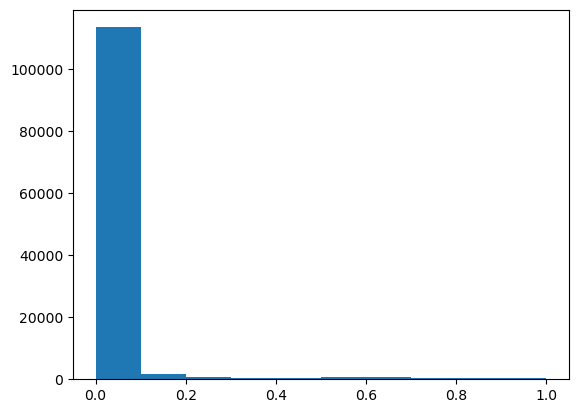

In [24]:
from matplotlib import pyplot as plt
plt.hist(df_comms1['Percent_commuters'])

(array([ 14.,  73., 216., 367., 433., 504., 486., 429., 402., 220.]),
 array([0.14716188, 0.23244569, 0.3177295 , 0.40301331, 0.48829713,
        0.57358094, 0.65886475, 0.74414856, 0.82943238, 0.91471619,
        1.        ]),
 <BarContainer object of 10 artists>)

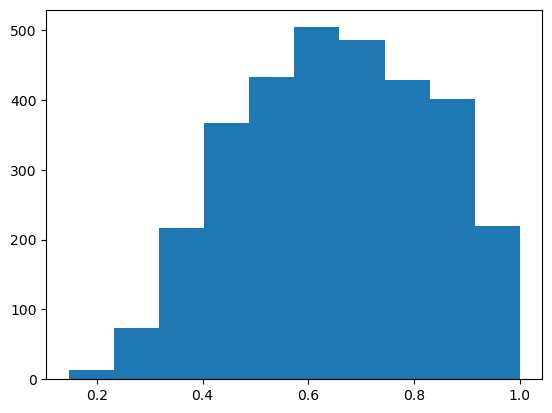

In [25]:
from matplotlib import pyplot as plt
a = df_comms1[df_comms1['Origin'] == df_comms1['Destination']]
plt.hist(a['Percent_commuters'])

In [18]:
#join vmt data on to df_comms and then apply percent 
df_comms2 = df[['full_fips_code', 'VMT', 'YEAR']].merge(df_comms1[['']], how = 'left', right_on = ['Origin'], left_on = ['full_fips_code'])
df_comms2

,Unnamed: 0,STATE_CODE,COUNTY_CODE,YEAR,VMT,POPULATION,TOTAL_EMISSIONS,True_GDP,True_Fips,Unemployment_Rate,...,adjacent_VMT,adjacent_POPULATION,adjacent_GDP,adjacent_EMISSIONS,Origin,Destination,Workers in Commuting Flow,Margin of Error,Summed Commuters,Percent_commuters
0,0,1,1,2000,274449272.4,44021.0,NaN,NaN,NaN,4.1,...,2.384363e+09,389154.0,0.0,0.000000e+00,01001,01001,8671.0,681,24949.0,0.347549
1,0,1,1,2000,274449272.4,44021.0,NaN,NaN,NaN,4.1,...,2.384363e+09,389154.0,0.0,0.000000e+00,01001,01003,8.0,12,24949.0,0.000321
2,0,1,1,2000,274449272.4,44021.0,NaN,NaN,NaN,4.1,...,2.384363e+09,389154.0,0.0,0.000000e+00,01001,01007,11.0,19,24949.0,0.000441
3,0,1,1,2000,274449272.4,44021.0,NaN,NaN,NaN,4.1,...,2.384363e+09,389154.0,0.0,0.000000e+00,01001,01013,9.0,17,24949.0,0.000361
4,0,1,1,2000,274449272.4,44021.0,NaN,NaN,NaN,4.1,...,2.384363e+09,389154.0,0.0,0.000000e+00,01001,01021,508.0,195,24949.0,0.020362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400706,60869,56,45,2020,56497022.7,6818.0,65850.124831,292568.0,56045.0,3.9,...,1.664054e+09,221071.0,13512319.0,1.889523e+06,56045,46047,27.0,42,2832.0,0.009534
2400707,60869,56,45,2020,56497022.7,6818.0,65850.124831,292568.0,56045.0,3.9,...,1.664054e+09,221071.0,13512319.0,1.889523e+06,56045,46081,35.0,55,2832.0,0.012359
2400708,60869,56,45,2020,56497022.7,6818.0,65850.124831,292568.0,56045.0,3.9,...,1.664054e+09,221071.0,13512319.0,1.889523e+06,56045,56005,595.0,163,2832.0,0.210099
2400709,60869,56,45,2020,56497022.7,6818.0,65850.124831,292568.0,56045.0,3.9,...,1.664054e+09,221071.0,13512319.0,1.889523e+06,56045,56011,74.0,46,2832.0,0.026130


In [14]:
# join onto 

,Unnamed: 0,STATE_CODE,COUNTY_CODE,YEAR,VMT,POPULATION,TOTAL_EMISSIONS,True_GDP,True_Fips,Unemployment_Rate,...,TELEWORK,distributed_UPT,GEMS_Typo,USDA_UIC,full_fips_code,origin,adjacent_VMT,adjacent_POPULATION,adjacent_GDP,adjacent_EMISSIONS
0,0,1,1,2000,2.744493e+08,44021.0,NaN,NaN,NaN,4.1,...,NaN,0.0,F,2.0,01001,01001,2.384363e+09,389154.0,0.0,0.000000e+00
1,1,1,3,2000,1.196020e+09,141342.0,NaN,NaN,NaN,3.7,...,NaN,0.0,C,2.0,01003,01003,3.854697e+09,803362.0,0.0,0.000000e+00
2,2,1,5,2000,1.276073e+08,29015.0,NaN,NaN,NaN,5.6,...,NaN,0.0,C,6.0,01005,01005,9.294242e+08,156251.0,0.0,0.000000e+00
3,3,1,7,2000,9.060923e+07,19913.0,NaN,NaN,NaN,5.4,...,NaN,0.0,D,1.0,01007,01007,6.770677e+09,1042021.0,0.0,0.000000e+00
4,4,1,9,2000,2.181014e+08,51107.0,NaN,NaN,NaN,3.5,...,NaN,0.0,D,1.0,01009,01009,6.583583e+09,1060903.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60865,60865,56,37,2020,8.070806e+08,42190.0,896451.459129,3344988.0,56037.0,7.5,...,0.087175,0.0,C,8.0,56037,56037,2.763250e+09,200489.0,13913205.0,3.008354e+06
60866,60866,56,39,2020,1.738602e+08,23377.0,272610.823838,2308166.0,56039.0,6.0,...,0.112992,0.0,D,8.0,56039,56039,2.171891e+09,378348.0,20055286.0,2.871878e+06
60867,60867,56,41,2020,2.682344e+08,20457.0,341765.799203,785684.0,56041.0,6.4,...,0.087175,0.0,D,8.0,56041,56041,1.884050e+09,127286.0,8212989.0,2.020111e+06
60868,60868,56,43,2020,4.965127e+07,7658.0,64261.255841,345111.0,56043.0,5.3,...,0.053399,0.0,B,11.0,56043,56043,1.263935e+09,181367.0,9444080.0,1.739361e+06


In [18]:
df.to_csv('adjacent_draft1.csv', index = False)

In [22]:
10**(10.5) - 10**(10)

21622776601.683792

In [26]:
10**(12.5) - 10**(12)

2162277660168.3794